# TASK #1: PROJECT OVERVIEW


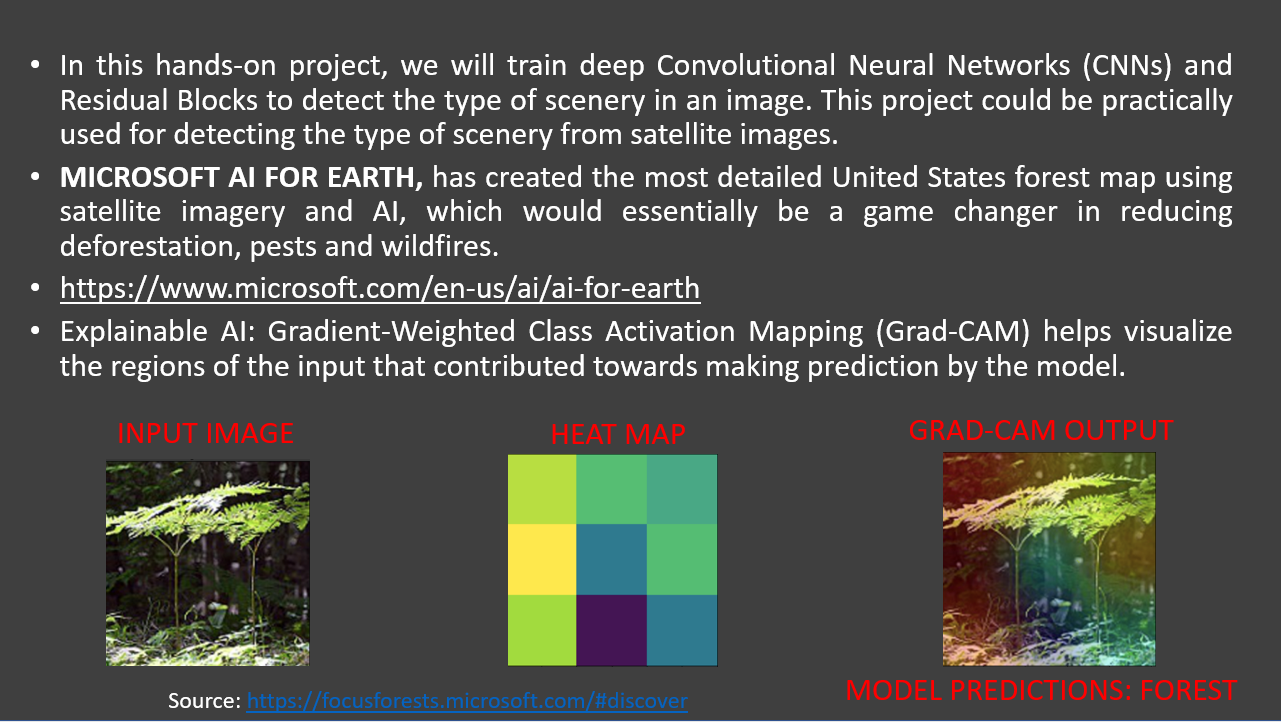


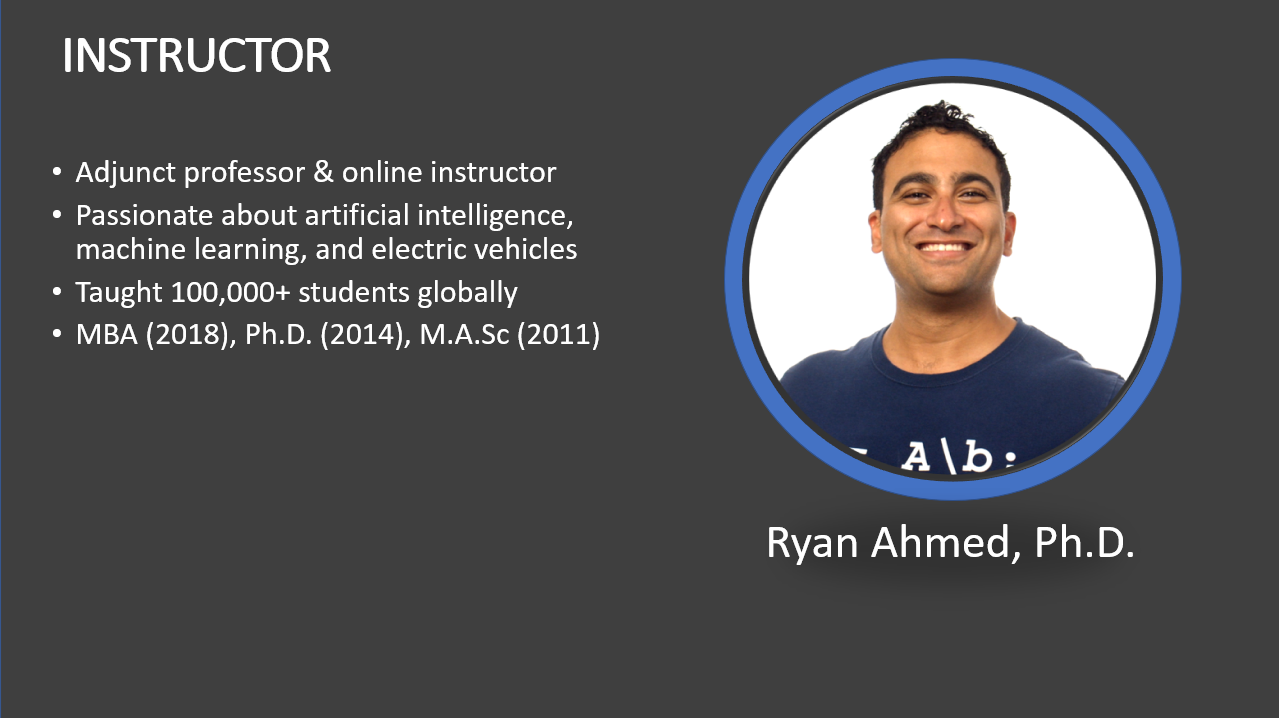


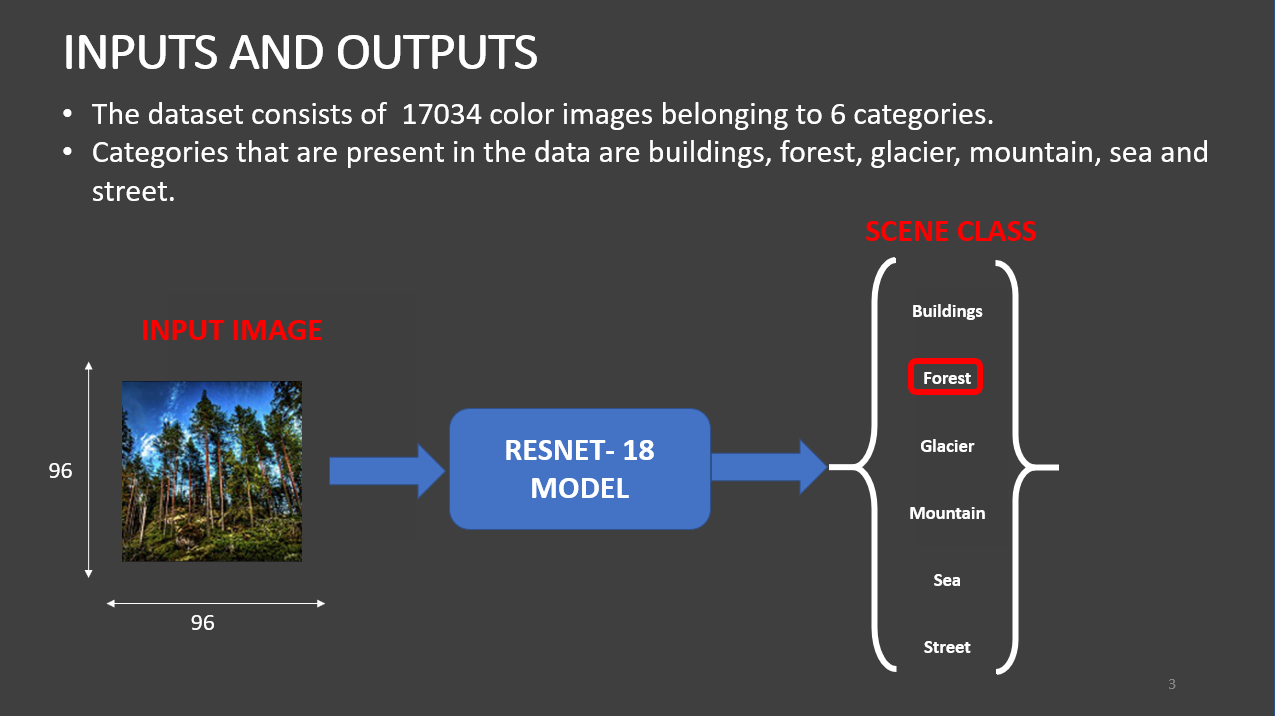


# TASK #2: IMPORT LIBRARIES/DATASETS


In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler,
)
import os
import PIL
from jupyterthemes import jtplot

jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
# setting the style of the notebook to be monokai theme
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them.


2026-01-10 21:31:45.014083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-10 21:31:45.025668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-10 21:31:45.029018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-10 21:31:45.038324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 21:31:45.732903: W tensorflow/compiler/tf2

In [2]:
classes = os.listdir("./seg_train")
n_class = len(classes)

print(f"Number of classes: {n_class}")
print(f"Classes: {classes}")

Number of classes: 6
Classes: ['glacier', 'sea', 'mountain', 'forest', 'street', 'buildings']


In [3]:
# Check the number of images in training, validation and test dataset

train = []
test = []

# os.listdir returns the list of files in the folder, in this case image class names
for c in classes:
    # list of images having a certain given class
    train_class = os.listdir(os.path.join("seg_train", c))
    # Extends the list instead of appending another list inside!
    train.extend(train_class)
    test_class = os.listdir(os.path.join("seg_test", c))
    test.extend(test_class)

print(f"Number of train images: {len(train)}")
print(f"Number of test images:  {len(test)}")

Number of train images: 14034
Number of test images:  3000


# TASK #3: DATA EXPLORATION AND DATA VISUALIZATION:


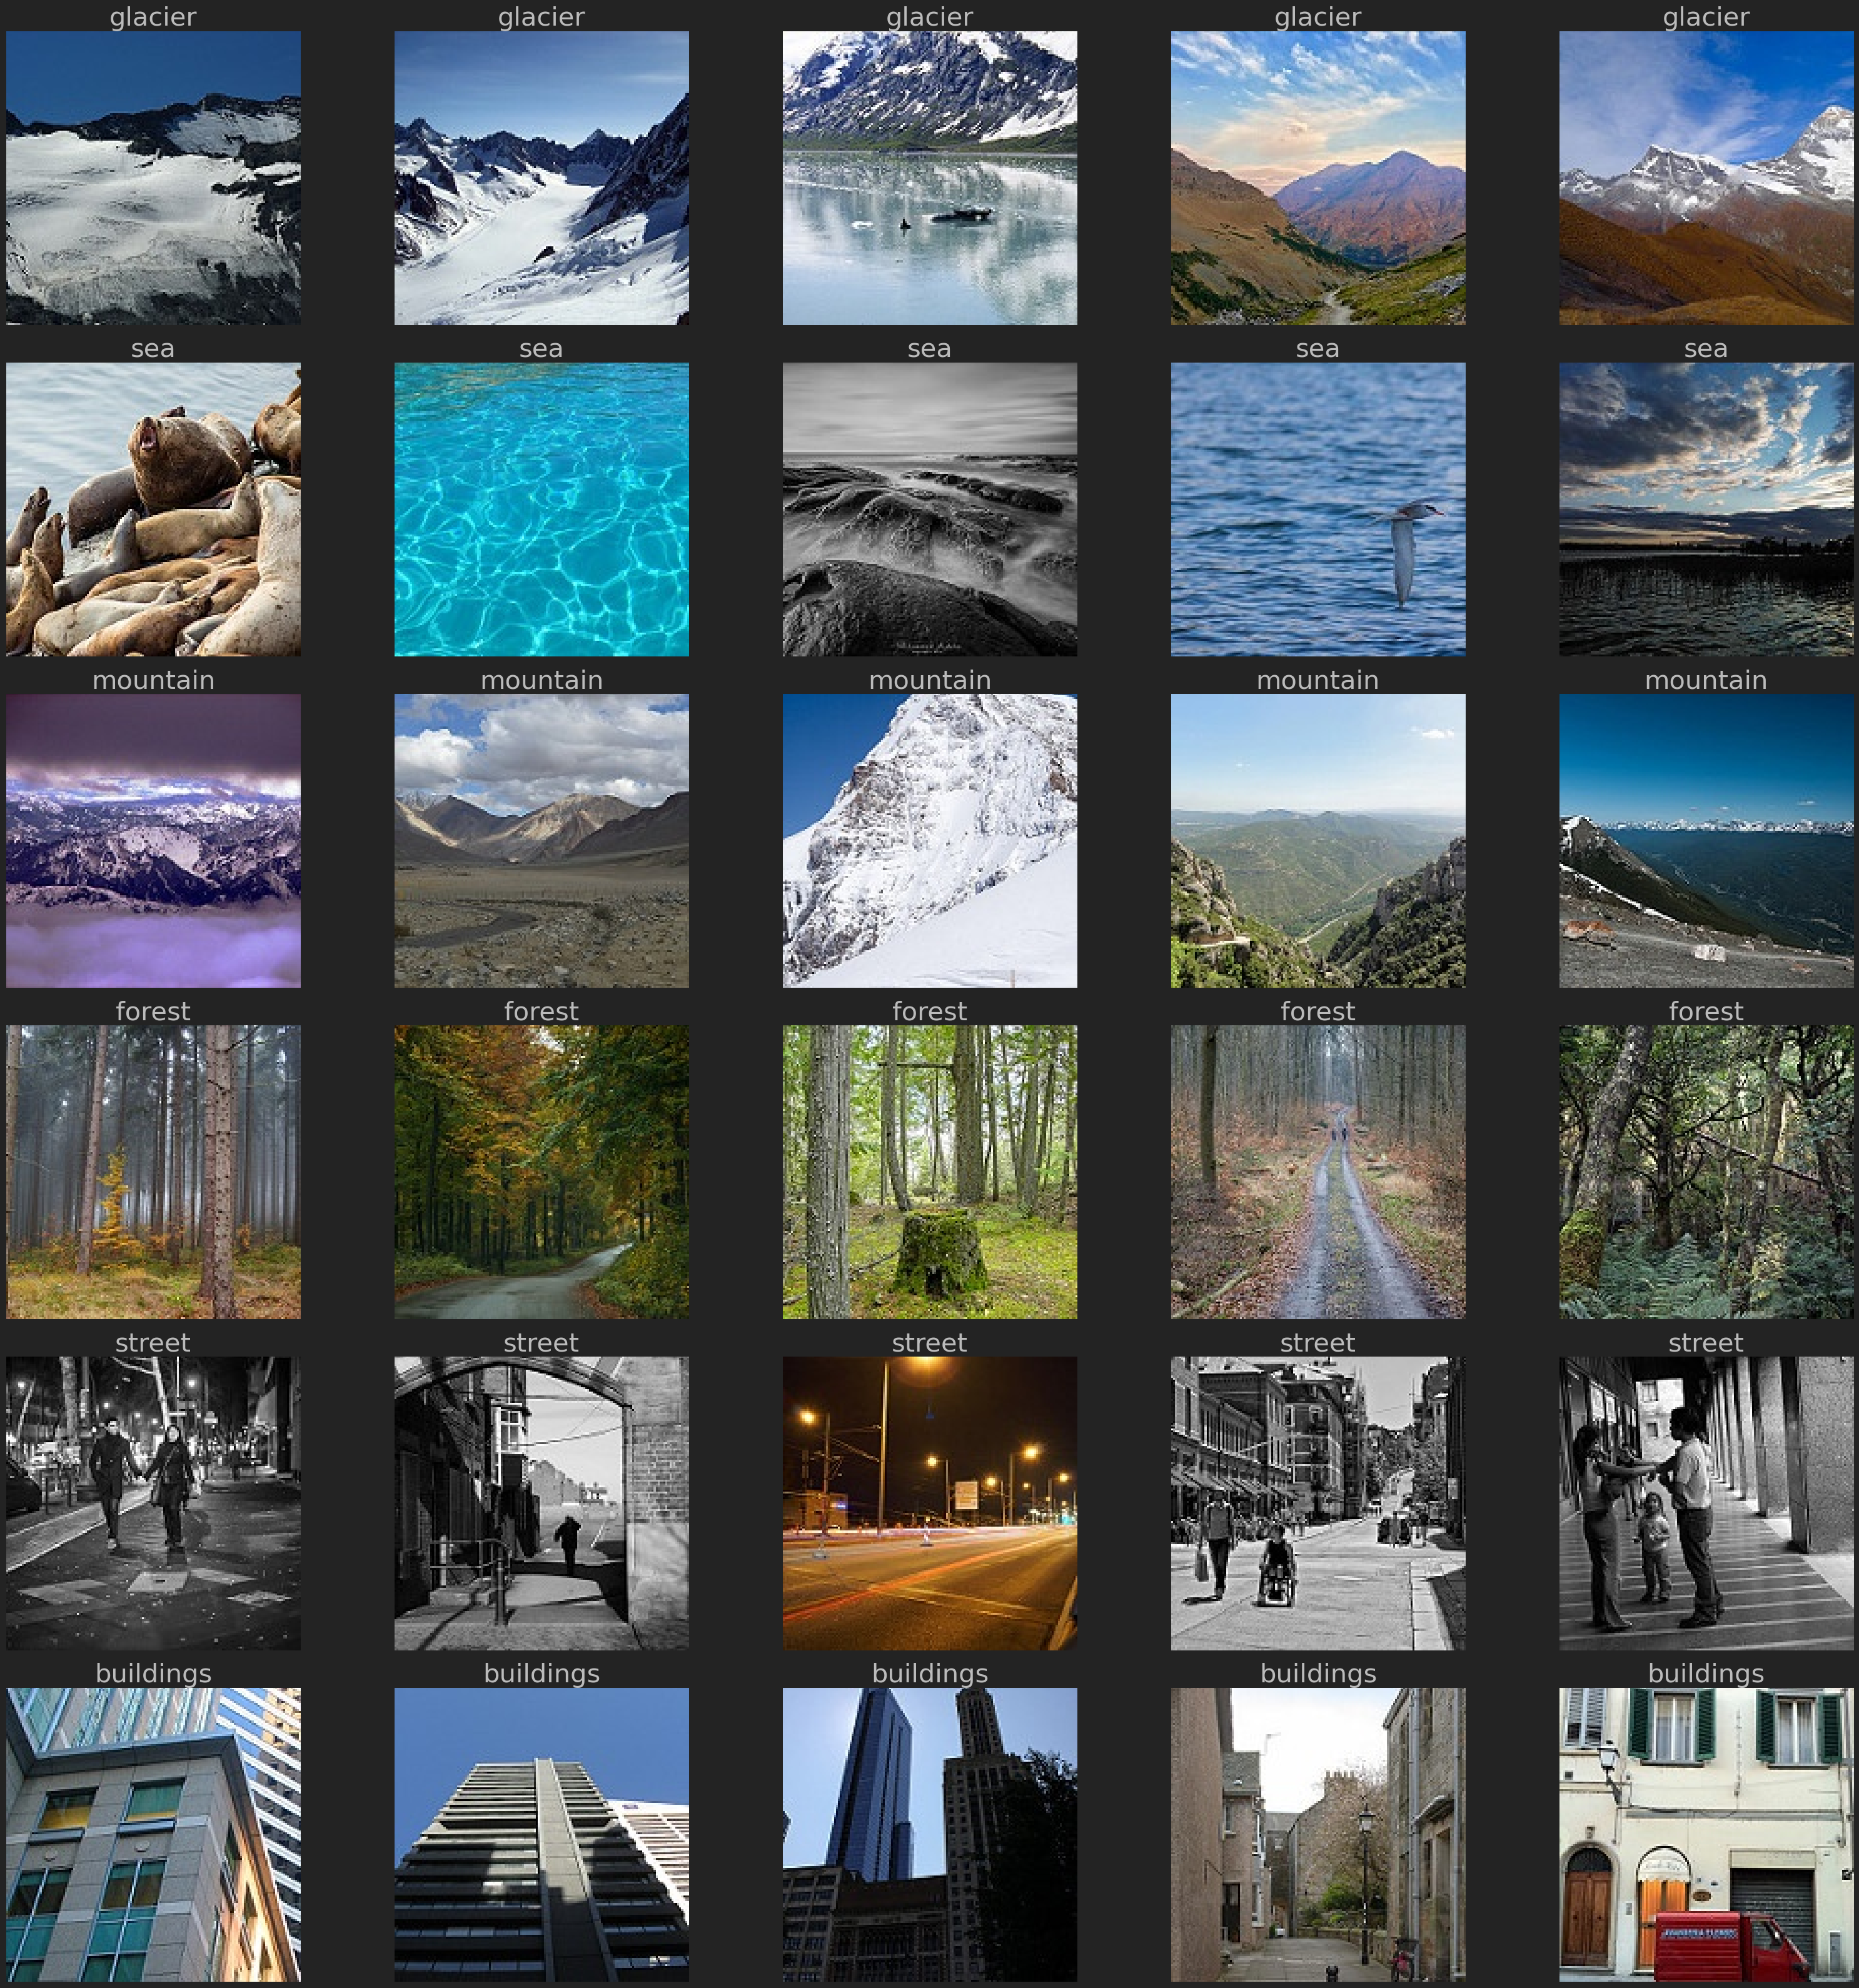

In [4]:
# Visualize the images in the dataset

fig, axs = plt.subplots(n_class, 5, figsize=(32, 32))
for class_num, class_name in enumerate(classes):
    # get the list of images in the particular class
    train_class = os.listdir(os.path.join("seg_train", class_name))
    # plot 5 images per class
    for img_num, img_name in enumerate(train_class[:5]):
        img_path = os.path.join("seg_train", class_name, img_name)
        img = PIL.Image.open(img_path)
        axs[class_num, img_num].imshow(img)
        axs[class_num, img_num].set_title(class_name, fontsize=30)
        axs[class_num, img_num].axis("off")

fig.tight_layout()
plt.show()

In [5]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir("./seg_train"):
    train_class = os.listdir(os.path.join("seg_train", i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print("Number of images in {} = {} \n".format(i, len(train_class)))

Number of images in glacier = 2404 

Number of images in sea = 2274 

Number of images in mountain = 2512 

Number of images in forest = 2271 

Number of images in street = 2382 

Number of images in buildings = 2191 



In [6]:
Class_name

['glacier', 'sea', 'mountain', 'forest', 'street', 'buildings']

In [7]:
No_images_per_class

[2404, 2274, 2512, 2271, 2382, 2191]

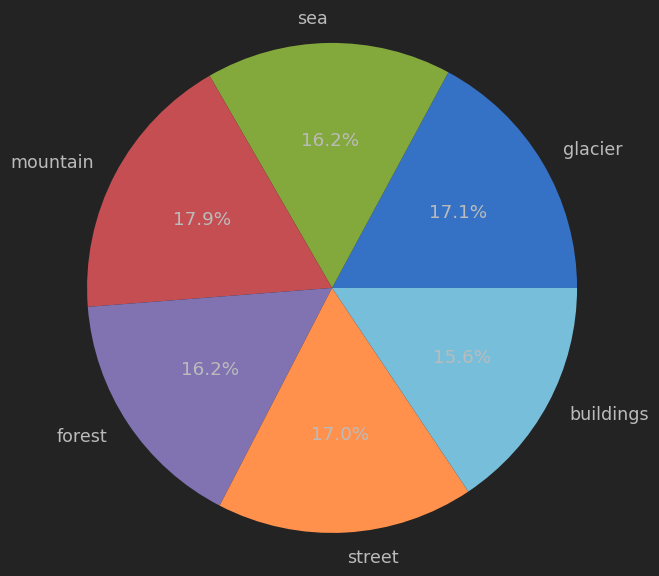

In [ ]:
# plot pie chart
fig1, ax1 = plt.subplots()

# draw pie chart with autopct to show percentage
ax1.pie(No_images_per_class, labels=Class_name, autopct="%1.1f%%")

ax1.title.set_text("Training Data")
ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

MINI CHALLENGE #1:

- Create a similar visualization but for the testing dataset instead of the training dataset.


In [9]:
test_class_img_count = {}

for c in classes:
    test_class = os.listdir(os.path.join("seg_test", c))
    test_class_img_count[c] = len(test_class)

test_class_img_count

{'glacier': 553,
 'sea': 510,
 'mountain': 525,
 'forest': 474,
 'street': 501,
 'buildings': 437}

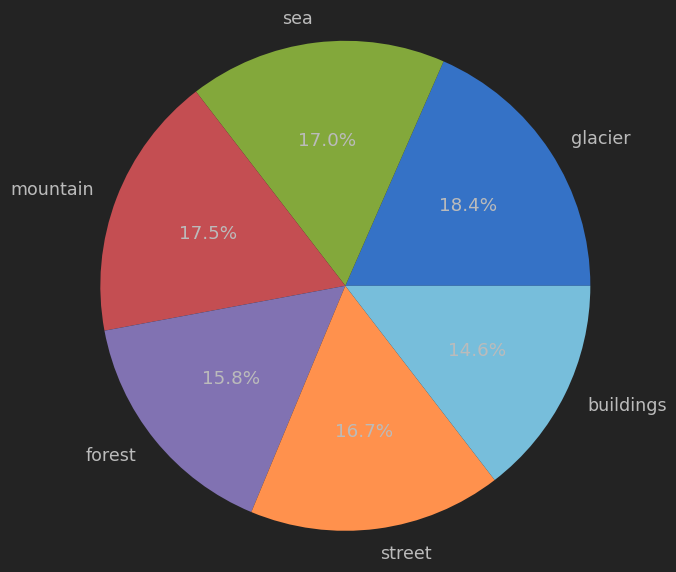

In [ ]:
fig2, ax2 = plt.subplots()

ax2.pie(
    test_class_img_count.values(), labels=test_class_img_count.keys(), autopct="%1.1f%%"
)

ax2.title.set_text("Testing Data")

ax2.axis("equal")
plt.show()

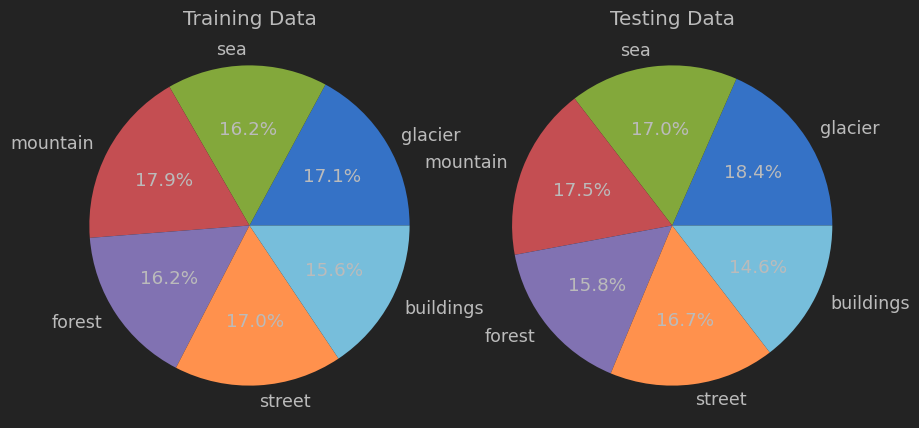

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(No_images_per_class, labels=Class_name, autopct="%1.1f%%")
ax1.title.set_text("Training Data")
ax1.axis("equal")
ax2.pie(
    test_class_img_count.values(), labels=test_class_img_count.keys(), autopct="%1.1f%%"
)
ax2.title.set_text("Testing Data")
ax2.axis("equal")
plt.savefig("figures/class_distribution.png")
plt.show()

# TASK #4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR


In [11]:
# create run-time augmentation on training and test dataset

# For training, we add normalization, shear angle, zooming range and horizontal flip
# 1. Normalisation (1.0 / 255) - Mathematical compatibility of data by scaling the pixel values to a range of 0 to 1
# 2. Shear Angle, 3. Zooming Range, 4. Horizontal Flip - To make model robust to different angles and scales of the objects in the image

# # --- DEPRECATED CODE ---
# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
#     validation_split=0.15,  # 15% of training data used for validation
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )

data_augmentation = keras.Sequential(
    [
        layers.RandomShear(0.2),
        layers.RandomZoom(0.2),
        layers.RandomFlip("horizontal"),
    ]
)

# For testing, we only normalize the data, no other transformation, to prevent false negative results as labels are changed after augmentation

IMG_DIM = 256

resize_and_rescale = keras.Sequential(
    [
        layers.Resizing(IMG_DIM, IMG_DIM),
        layers.Rescaling(1.0 / 255),
    ]
)

I0000 00:00:1768060916.152384   13018 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1768060916.191245   13018 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1768060916.195295   13018 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1768060916.198943   13018 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [12]:
# # DEPRECATED: Creating datagenerator for training, validation and test dataset.

# train_generator = train_datagen.flow_from_directory(
#     "seg_train",
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode="categorical",
#     subset="training",
# )

# validation_generator = train_datagen.flow_from_directory(
#     "seg_train",
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode="categorical",
#     subset="validation",
# )

# 1. Define the Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "seg_train",
    validation_split=0.2,  # Replaces validation_split in ImageDataGenerator
    subset="training",
    seed=0,  # CRITICAL: Ensures train/val split doesn't overlap
    image_size=(256, 256),  # Replaces 'target_size'
    batch_size=32,
    label_mode="categorical",  # Replaces 'class_mode'
)

# 2. Define the Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "seg_train",
    validation_split=0.2,
    subset="validation",
    seed=0,  # Must match the seed above!
    image_size=(256, 256),
    batch_size=32,
    label_mode="categorical",
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


MINI CHALLENGE #2:

- Experiment with other image augmentation strategies to the training data. Pick at least 1 augmentation strategy.

HINT: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator


In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1.0 / 255),
        layers.RandomFlip("horizontal_and_vertical", seed=0),
        layers.RandomZoom(0.2, seed=0),
        layers.RandomShear(0.2, seed=0),
        layers.RandomRotation(0.1, seed=0),
        layers.RandomContrast(0.1, seed=0),
        layers.RandomBrightness(0.1, seed=0),
    ]
)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS (CNN) AND RESIDUAL BLOCKS


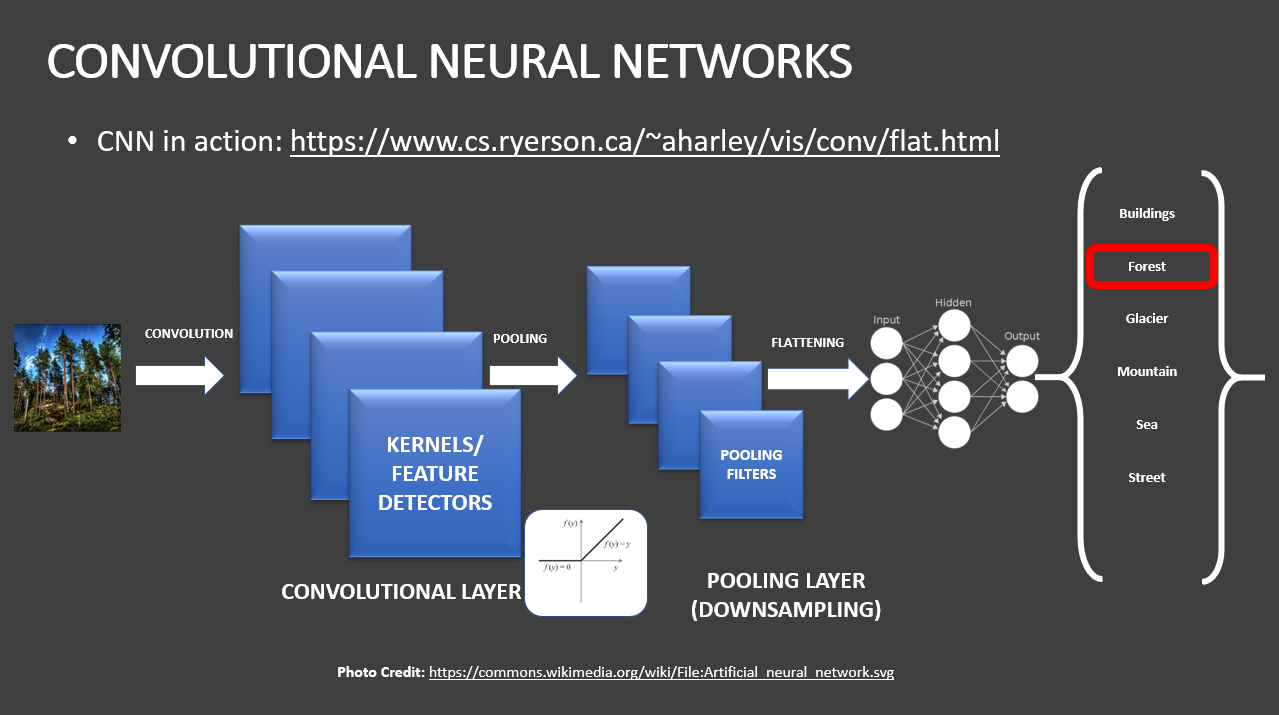


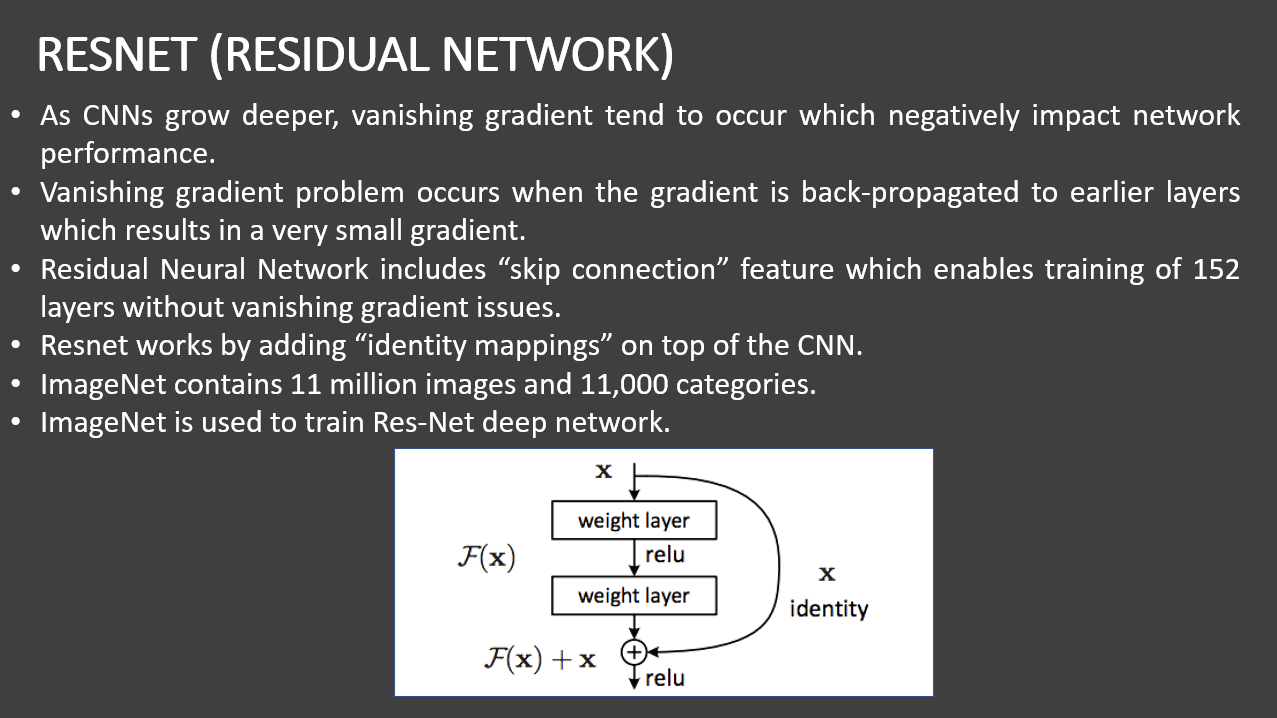


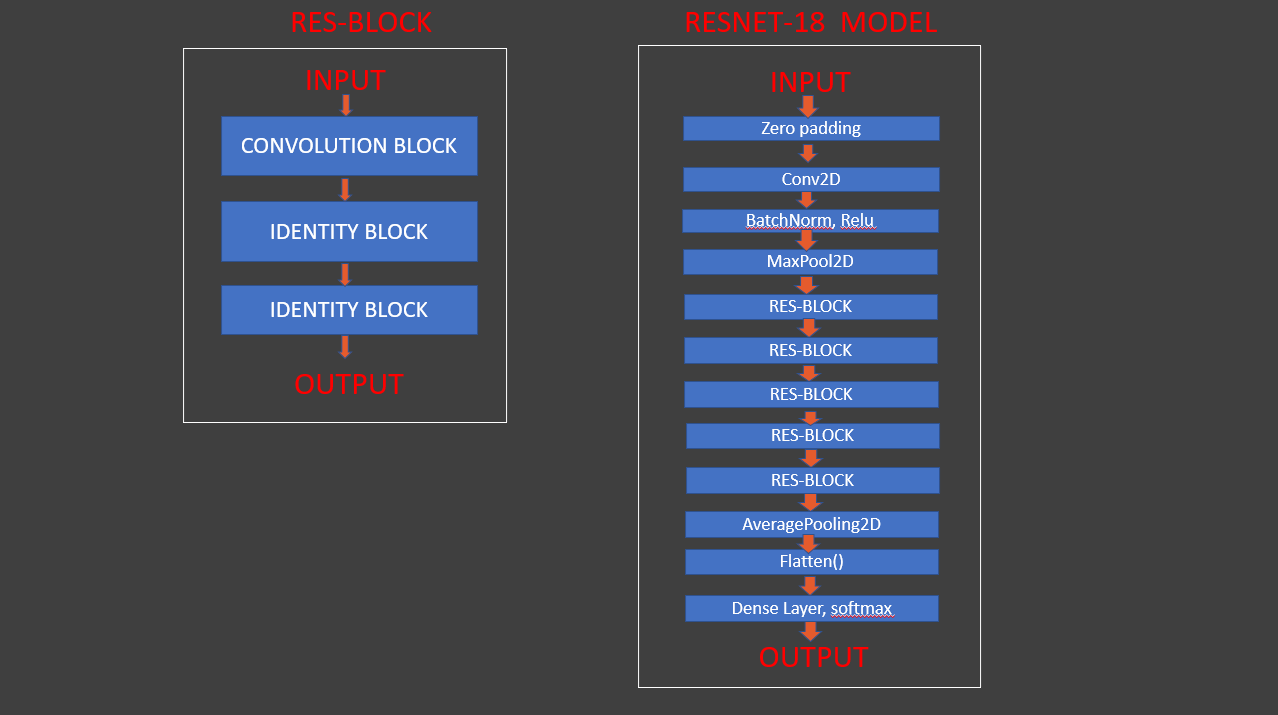


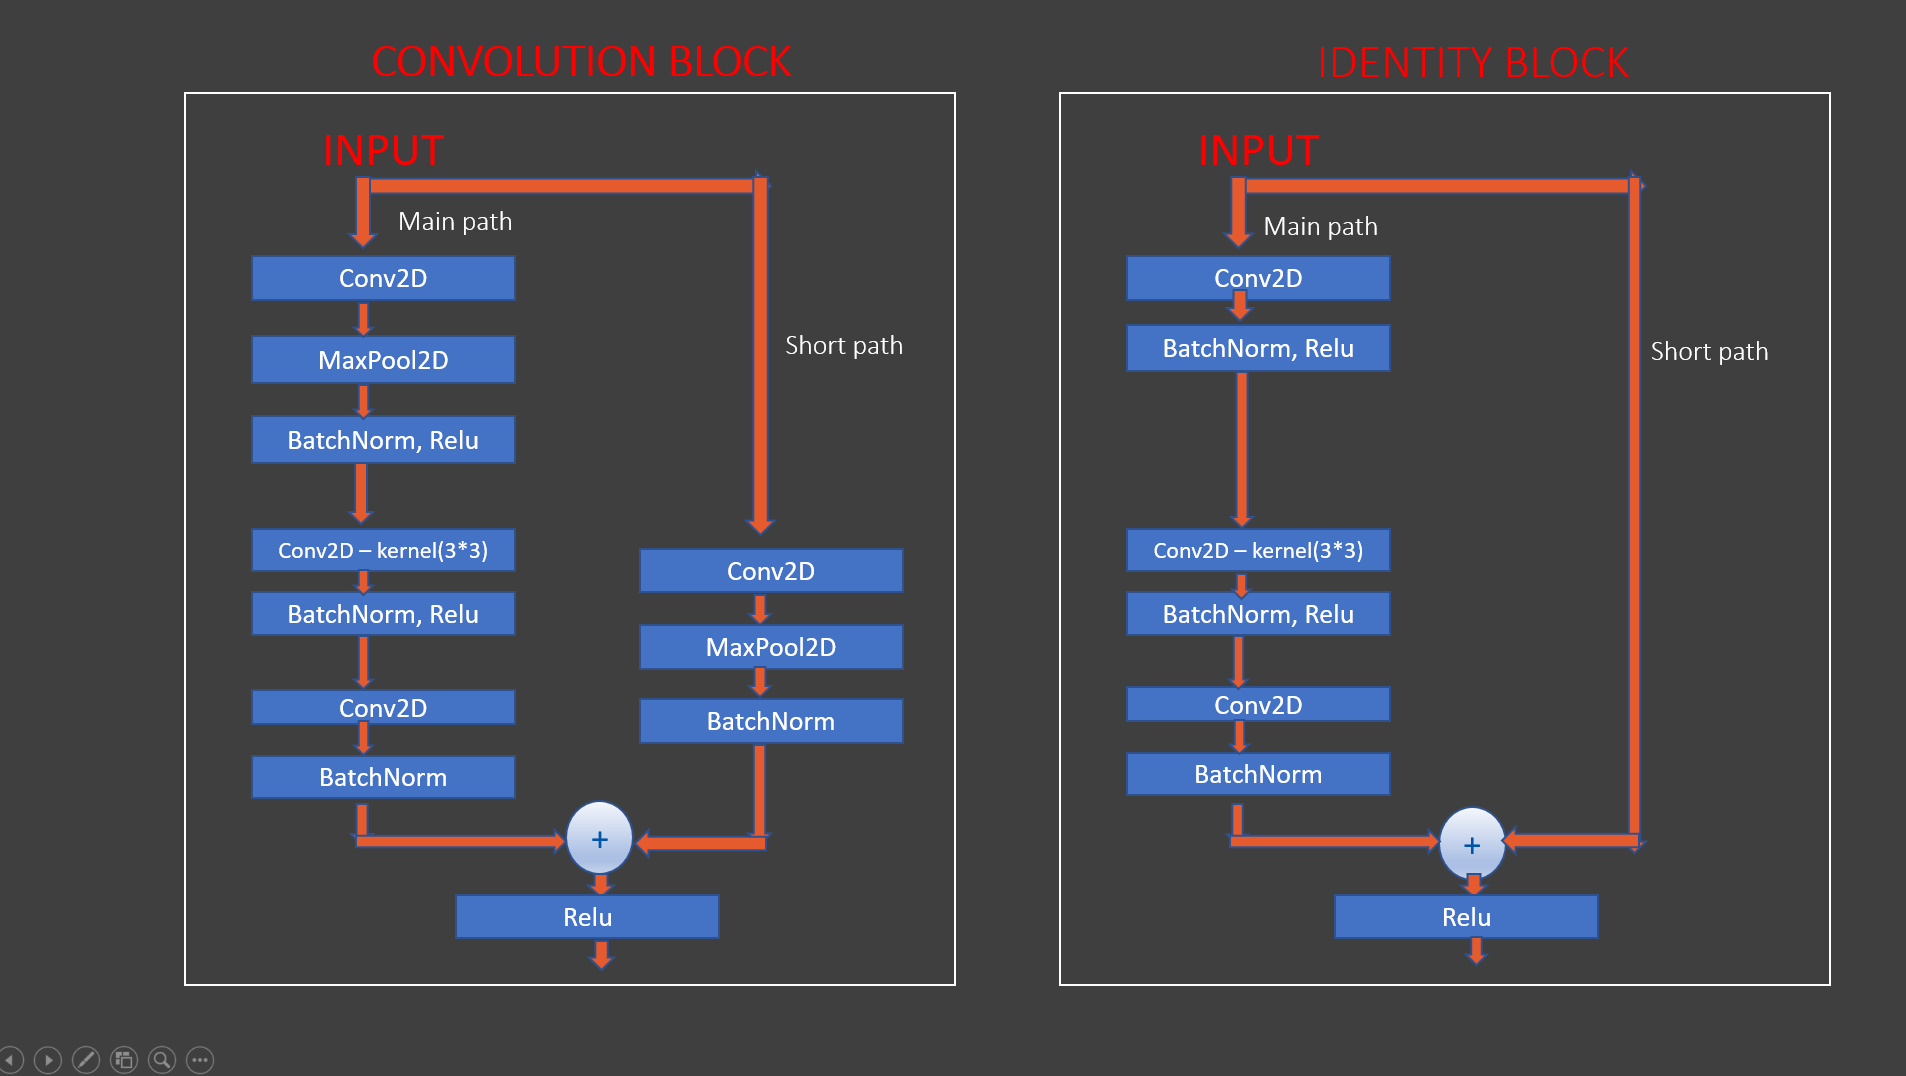


MINI CHALLENGE #3:

- What is the performance of ResNets on the ImageNet datasets? (External Research is required)


**Ans.:** Better than VGG and AlexNet, with ResNet-50 achieving a top-5 error rate of 3.6% on the ImageNet validation set. It's even better than human-level performance, which is around 5.1%.


# TASK #6: BUILD RESNET MODEL


In [14]:
def conv_block(
    X: tf.Tensor, fltr: tuple[int, int, int], stage: int | None = None
) -> tf.Tensor:
    """
    X: input 3D image feature vector
    fltr: tuple of 3 integers - each defining the NUMBER of kernels applied per image and hence, the number of activation maps generated!
    stage: current stage in the ResNet architecture
    """

    f1, f2, f3 = fltr

    # ---MAIN PATH---
    X_main = X

    X_main = layers.Conv2D(
        filters=f1,
        kernel_size=(1, 1),
        strides=(2, 2),
        name="res_" + ((str(stage) + "_") if stage is not None else "") + "conv_a",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    # X_main = layers.MaxPool2D((2, 2))(X_main) - Replaced with strides
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_" + ((str(stage) + "_") if stage is not None else "") + "conv_a",
    )(X_main)
    X_main = layers.Activation("relu")(X_main)

    X_main = layers.Conv2D(
        filters=f2,
        kernel_size=(3, 3),
        padding="same",
        name="res_" + ((str(stage) + "_") if stage is not None else "") + "conv_b",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_" + ((str(stage) + "_") if stage is not None else "") + "conv_b",
    )(X_main)
    X_main = layers.Activation("relu")(X_main)

    X_main = layers.Conv2D(
        filters=f3,
        kernel_size=(1, 1),
        name="res_" + ((str(stage) + "_") if stage is not None else "") + "conv_c",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_" + ((str(stage) + "_") if stage is not None else "") + "conv_c",
    )(X_main)

    # ---SHORT PATH---
    X_short = X
    X_short = layers.Conv2D(
        filters=f3,
        kernel_size=(1, 1),
        strides=(2, 2),
        name="res_"
        + str(stage)
        + ("_" if stage is not None else "")
        + "conv_shortpath",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_short)
    # X_short = layers.MaxPool2D((2, 2))(X_short) - Replaced with strides
    X_short = layers.BatchNormalization(
        axis=3,
        name="bn_"
        + ((str(stage) + "_") if stage is not None else "")
        + "conv_shortpath",
    )(X_short)

    # ---ADD---
    X_final = layers.Add()([X_main, X_short])
    X_final = layers.Activation("relu")(X_final)

    return X_final

In [15]:
def identity_block(
    X: tf.Tensor,
    fltr: tuple[int, int, int],
    stage: int | None = None,
    identity_no: int | None = None,
) -> tf.Tensor:
    """
    X: input 3D image feature vector
    fltr: tuple of 3 integers - each defining the NUMBER of kernels applied per image and hence, the number of activation maps generated!
    stage: current stage in the ResNet architecture
    """

    f1, f2, f3 = fltr

    # ---MAIN PATH---
    X_main = X

    X_main = layers.Conv2D(
        filters=f1,
        kernel_size=(1, 1),
        name="res_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "a",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "a",
    )(X_main)
    X_main = layers.Activation("relu")(X_main)

    X_main = layers.Conv2D(
        filters=f2,
        kernel_size=(3, 3),
        padding="same",
        name="res_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "b",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "b",
    )(X_main)
    X_main = layers.Activation("relu")(X_main)

    X_main = layers.Conv2D(
        filters=f3,
        kernel_size=(1, 1),
        name="res_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "c",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_main)
    X_main = layers.BatchNormalization(
        axis=3,
        name="bn_"
        + ((str(stage) + "_") if stage is not None else "")
        + "identity_"
        + ((str(identity_no) + "_") if identity_no is not None else "")
        + "c",
    )(X_main)

    # ---SHORT PATH---
    X_short = X

    # ---ADD---
    X_final = layers.Add()([X_main, X_short])
    X_final = layers.Activation("relu")(X_final)

    return X_final

In [16]:
def res_block(X, filter, stage):
    """
    Wrapper that replaces the explicit implementation with the reusable
    conv_block (the downsampling convolutional block) followed by two
    identity_block calls.
    Assumes conv_block and identity_block are defined elsewhere in the notebook.
    """
    # Convolutional (downsampling) block
    X = conv_block(X, filter, stage)
    # Two identity blocks
    X = identity_block(X, filter, stage, 1)
    X = identity_block(X, filter, stage, 2)
    return X


In [17]:
# DEFINING MODEL USING FUNCTIONAL API

input_shape = (256, 256, 3)

# Input tensor shape
X_input = layers.Input(shape=input_shape)

X_input = data_augmentation(X_input)

# Zero-padding
X = layers.ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = layers.Conv2D(
    64, (7, 7), strides=(2, 2), name="conv1", kernel_initializer=glorot_uniform(seed=0)
)(X)
X = layers.BatchNormalization(axis=3, name="bn_conv1")(X)
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

# 2- stage
X = res_block(X, filter=[64, 64, 256], stage=2)

# 3- stage
X = res_block(X, filter=[128, 128, 512], stage=3)

# 4- stage
X = res_block(X, filter=[256, 256, 1024], stage=4)

# 5- stage
X = res_block(X, filter=[512, 512, 2048], stage=5)

# Average Pooling
X = layers.AveragePooling2D((2, 2), name="Average_Pooling")(X)

# Final layer
X = layers.Flatten()(X)
X = layers.Dropout(0.4)(X)
X = layers.Dense(
    6,
    activation="softmax",
    name="Dense_final",
    kernel_initializer=glorot_uniform(seed=0),
)(X)


model = Model(inputs=X_input, outputs=X, name="Resnet18")

model.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_9CLONE │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ keras_tensor_9CL… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 128, 128,  │      9,472 │ zero_padding2d[1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 128, 128,  │        256 │ conv1[1][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ bn_conv1[1][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ activation[1][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 32, 32,    │      4,160 │ max_pooling2d[1]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 32, 32,    │        256 │ res_2_conv_a[1][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ bn_2_conv_a[1][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 32, 32,    │     36,928 │ activation_1[1][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 32, 32,    │        256 │ res_2_conv_b[1][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ bn_2_conv_b[1][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 32, 32,    │     16,640 │ activation_2[1][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_shortpa… │ (None, 32, 32,    │     16,640 │ max_pooling2d[1]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 32, 32,    │      1,024 │ res_2_conv_c[1][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_shortpath │ (None, 32, 32,    │      1,024 │ res_2_conv_short… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ bn_2_conv_c[1][0

 Total params: 19,989,126 (76.25 MB)

 Trainable params: 19,946,758 (76.09 MB)

 Non-trainable params: 42,368 (165.50 KB)

MINI CHALLENGE #4:

- Try to remove max pooling layers from the residual blocks and add dropout layers to the model.


In [18]:
# Just comment out MaxPool2D layers and add X = layers.Dropout(0.4)(X) before final layer of dense network
# Done in main code

# TASK #7: COMPILE AND TRAIN DEEP LEARNING MODEL


In [19]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [20]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[checkpointer, earlystopping],
)

I0000 00:00:1768060960.737023   13481 service.cc:146] XLA service 0x713a6c004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768060960.737054   13481 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2026-01-10 21:32:41.267551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-10 21:32:43.286504: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/351 ━━━━━━━━━━━━━━━━━━━━ 2:46:12 28s/step - accuracy: 0.1875 - loss: 3.5609

I0000 00:00:1768060977.542519   13481 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4113 - loss: 3.2771
Epoch 1: val_loss improved from None to 17.96907, saving model to weights.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 142ms/step - accuracy: 0.5049 - loss: 2.3094 - val_accuracy: 0.3396 - val_loss: 17.9691


MINI CHALLENGE #5:

- Try a different optimizer and retrain the model (Take Home)
- Change the value of patience in early stopping


In [ ]:
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.8),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

earlystopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpointer, earlystopping],
)

Epoch 1/50


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9124 - loss: 0.2741
Epoch 1: val_loss improved from None to 0.46709, saving model to weights1.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 107ms/step - accuracy: 0.9171 - loss: 0.2681 - val_accuracy: 0.8396 - val_loss: 0.4671
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9122 - loss: 0.2589
Epoch 2: val_loss did not improve from 0.46709
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9154 - loss: 0.2522 - val_accuracy: 0.8403 - val_loss: 0.4712
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9108 - loss: 0.2802
Epoch 3: val_loss did not improve from 0.46709
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9184 - loss: 0.2600 - val_accuracy: 0.8407 - val_loss: 0.4698
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9198 - loss: 0.2819
Epoch 4: val_loss did not improve from 0.46709
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9204 - loss: 0.2567 - val_a

# TASK #8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL


In [ ]:
model.load_weights("weights.keras")

In [30]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "seg_test",
    seed=0,
    image_size=(256, 256),
    batch_size=32,
    label_mode="categorical",
)

Found 3000 files belonging to 6 classes.


In [31]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_ds, verbose=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8553 - loss: 0.4396


In [32]:
# assign label names to the corresponding indexes
labels = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street",
}

In [ ]:
# load images and their predictions

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir("./seg_test"):
    for item in os.listdir(os.path.join("./seg_test", i)):
        # code to open the image
        img = PIL.Image.open(os.path.join("./seg_test", i, item))
        # resizing the image to (256,256)
        img = img.resize((256, 256))
        # appending image to the image list
        image.append(img)
        # converting image to array
        img = np.asarray(img, dtype=np.float32)
        # reshaping the image into a 4D array
        img = img.reshape(-1, 256, 256, 3)
        # making prediction of the model
        predict = model.predict(img, verbose=0)
        # getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        # appending the predicted class to the list
        prediction.append(labels[predict])
        # appending original class to the list
        original.append(i)


In [38]:
# Get the test accuracy
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.8496666666666667


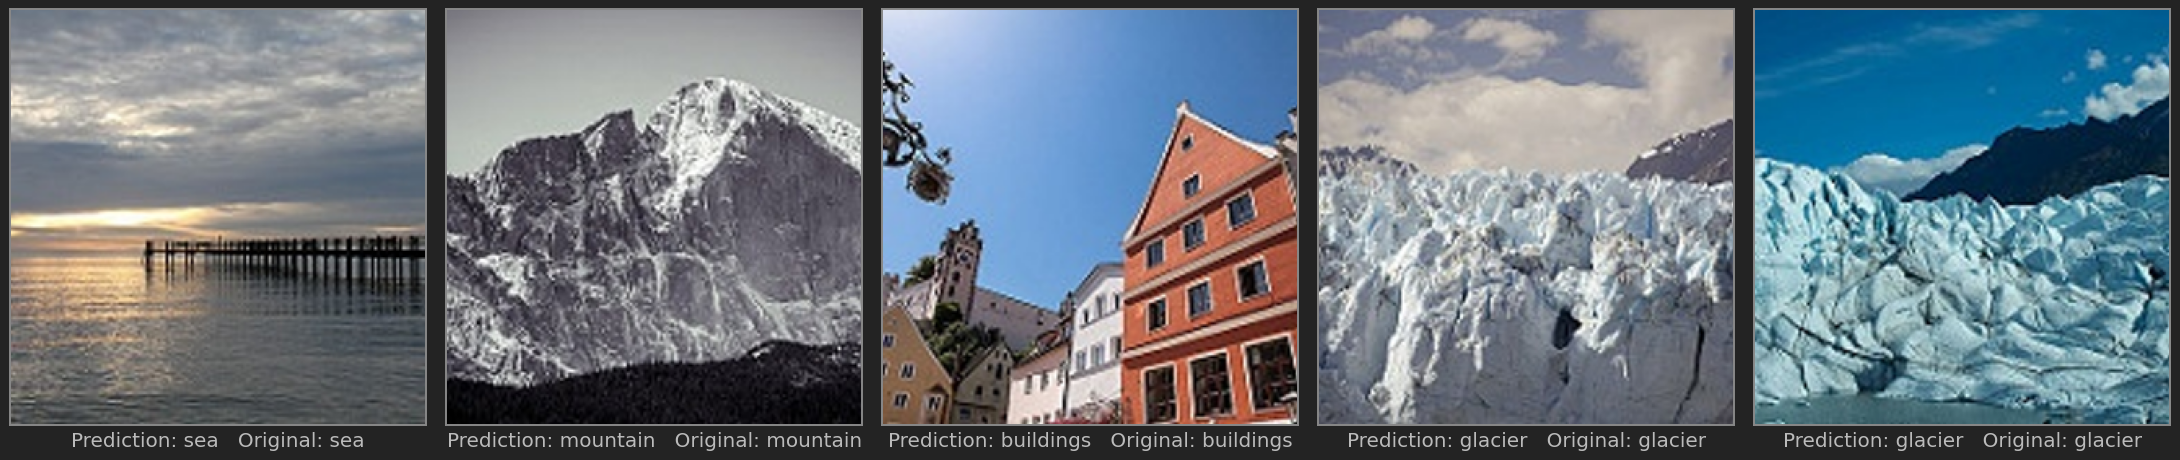

In [78]:
# visualize the results
import random

fig = plt.figure(figsize=(22, 5))
for i in range(5):
    j = random.randint(0, len(image))
    fig.add_subplot(1, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Prediction: " + prediction[j] + "   Original: " + original[j])
    plt.imshow(image[j])
plt.tight_layout()
plt.savefig("figures/sample_predictions.png")
plt.show()

MINI CHALLENGE #6:

- print out the classification report
- print out the confusion matrix and comment on the model performance


MINI CHALLENGE #7:

- What could be the reason for the model poor performance on the Glaciers class?


# TASK #9: UNDERSTAND THE THEORY AND INTUITION BEHIND GRADCAM


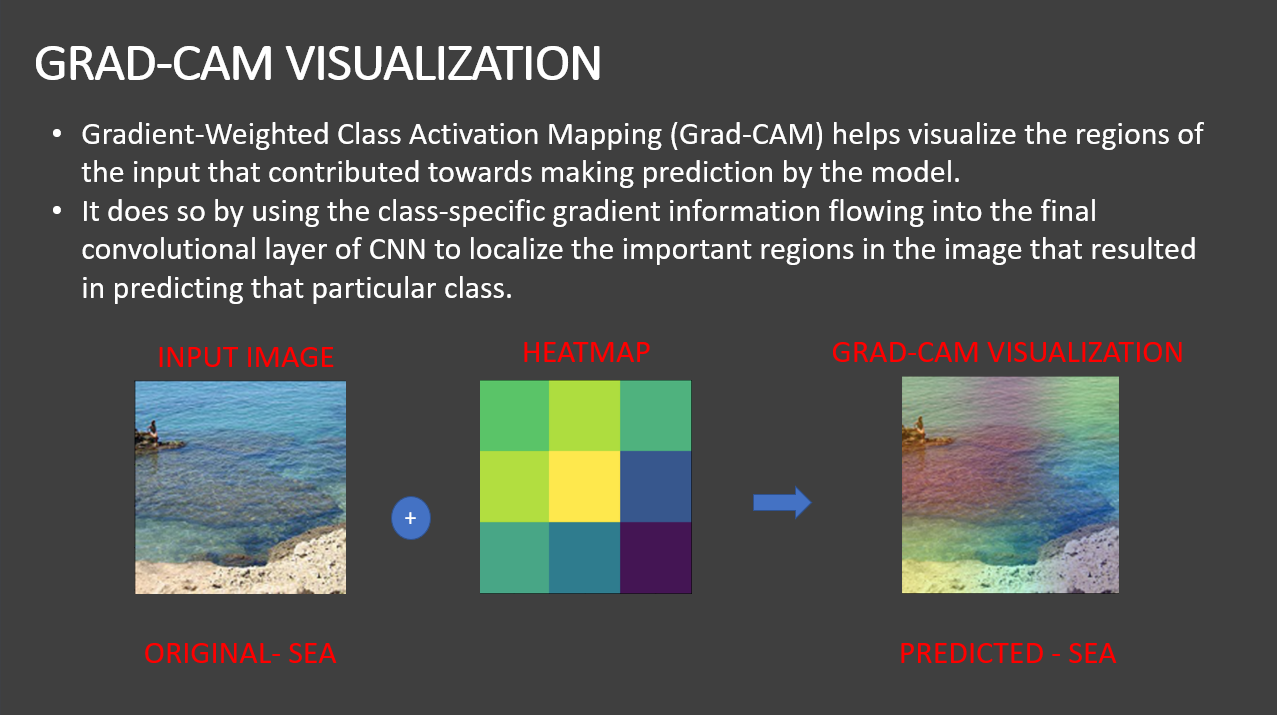


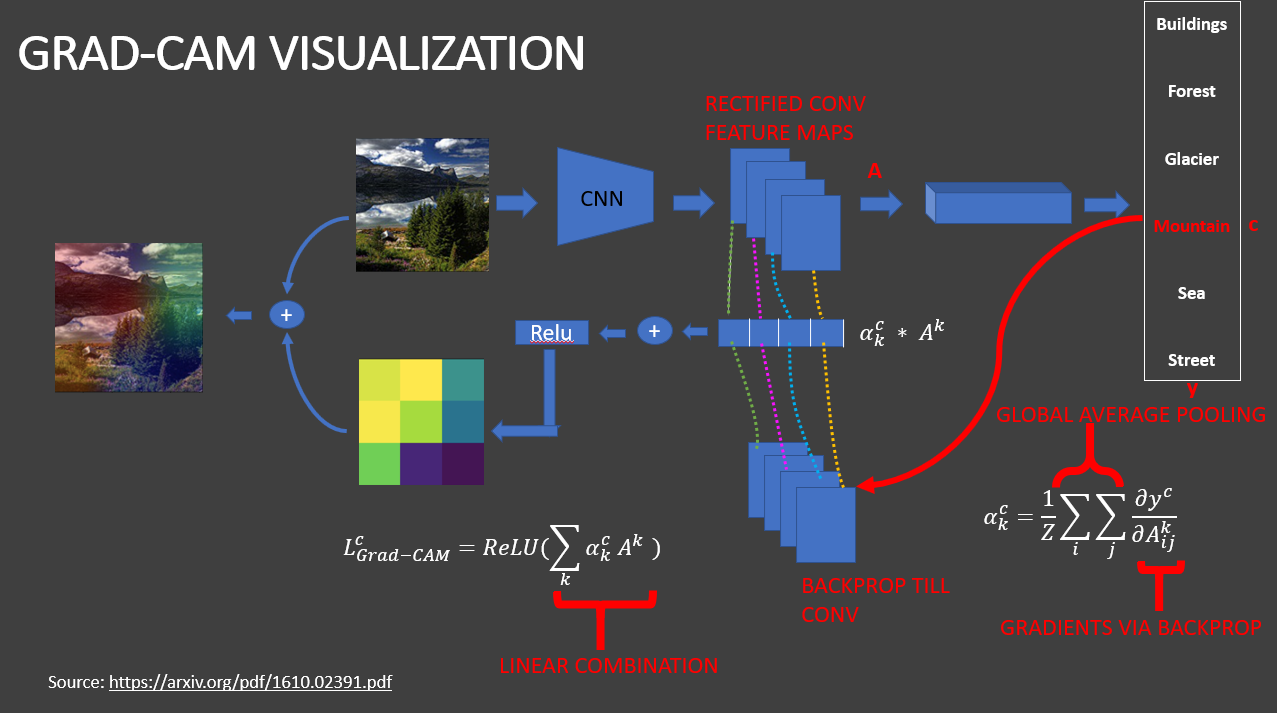


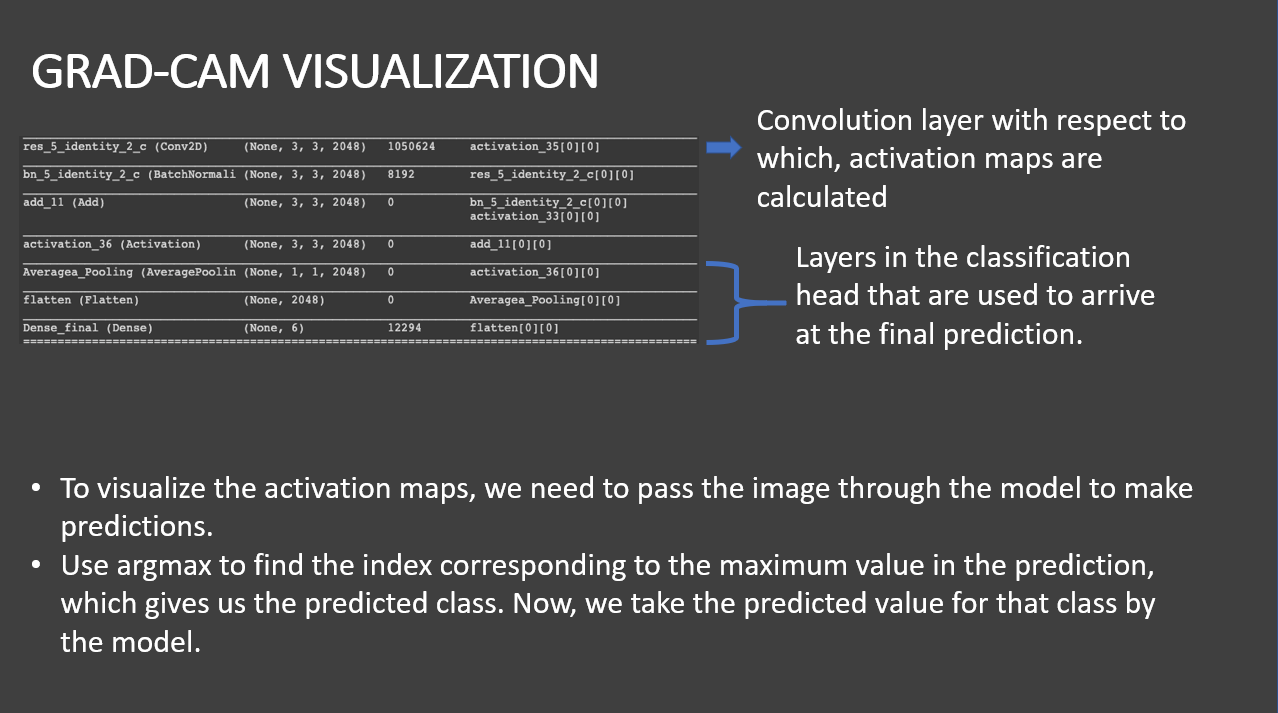


# TASK #10: VISUALIZING ACTIVATION MAPS THROUGH GRAD-CAM


In [ ]:
def grad_cam(img):
    # Convert the image to array of type float32
    img = np.asarray(img, dtype=np.float32)

    # Reshape the image from (256,256,3) to (1,256,256,3)
    img = img.reshape(-1, 256, 256, 3)
    img_scaled = img / 255

    # Name of the average pooling layer and dense final (you can see these names in the model summary)
    classification_layers = ["Averagea_Pooling", "Dense_final"]

    # Last convolutional layer in the model
    final_conv = model.get_layer("res_5_identity_2_c")

    # Create a model with original model inputs and the last conv_layer as the output
    final_conv_model = keras.Model(model.inputs, final_conv.output)

    # Then we create the input for classification layer, which is the output of last conv layer
    # In our case, output produced by the conv layer is of the shape (1,3,3,2048)
    # Since the classification input needs the features as input, we ignore the batch dimension

    classification_input = keras.Input(shape=final_conv.output.shape[1:])

    # We iterate through the classification layers, to get the final layer and then append
    # the layer as the output layer to the classification model.
    temp = classification_input
    for layer in classification_layers:
        temp = model.get_layer(layer)(temp)
    classification_model = keras.Model(classification_input, temp)

    # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
    # corresponding to the predicted class
    with tf.GradientTape() as tape:
        # Pass the image through the base model and get the feature map
        final_conv_output = final_conv_model(img_scaled)

        # Assign gradient tape to monitor the conv_output
        tape.watch(final_conv_output)

        # Pass the feature map through the classification model and use argmax to get the
        # index of the predicted class and then use the index to get the value produced by final
        # layer for that class
        prediction = classification_model(final_conv_output)

        predicted_class = tf.argmax(prediction[0][0][0])

        predicted_class_value = prediction[:, :, :, predicted_class]

    # Get the gradient corresponding to the predicted class based on feature map.
    # which is of shape (1,3,3,2048)
    gradient = tape.gradient(predicted_class_value, final_conv_output)

    # Since we need the filter values (2048), we reduce the other dimensions,
    # which would result in a shape of (2048,)
    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

    # We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)
    final_conv_output = final_conv_output.numpy()[0]

    gradient_channels = gradient_channels.numpy()

    # We multiply the filters in the feature map produced by final conv layer by the
    # filter values that are used to get the predicted class. By doing this we inrease the
    # value of areas that helped in making the prediction and lower the vlaue of areas, that
    # did not contribute towards the final prediction
    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

    # We take the mean accross the channels to get the feature map
    heatmap = np.mean(final_conv_output, axis=-1)

    # Normalizing the heat map between 0 and 1, to visualize it
    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

    # Rescaling and converting the type to int
    heatmap = np.uint8(255 * heatmap_normalized)

    # Create the colormap
    color_map = plt.cm.get_cmap("jet")

    # get only the rb features from the heatmap
    color_map = color_map(np.arange(256))[:, :3]
    heatmap = color_map[heatmap]

    # convert the array to image, resize the image and then convert to array
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((256, 256))
    heatmap = np.asarray(heatmap, dtype=np.float32)

    # Add the heatmap on top of the original image
    final_img = heatmap * 0.4 + img[0]
    final_img = keras.preprocessing.image.array_to_img(final_img)

    return final_img, heatmap_normalized


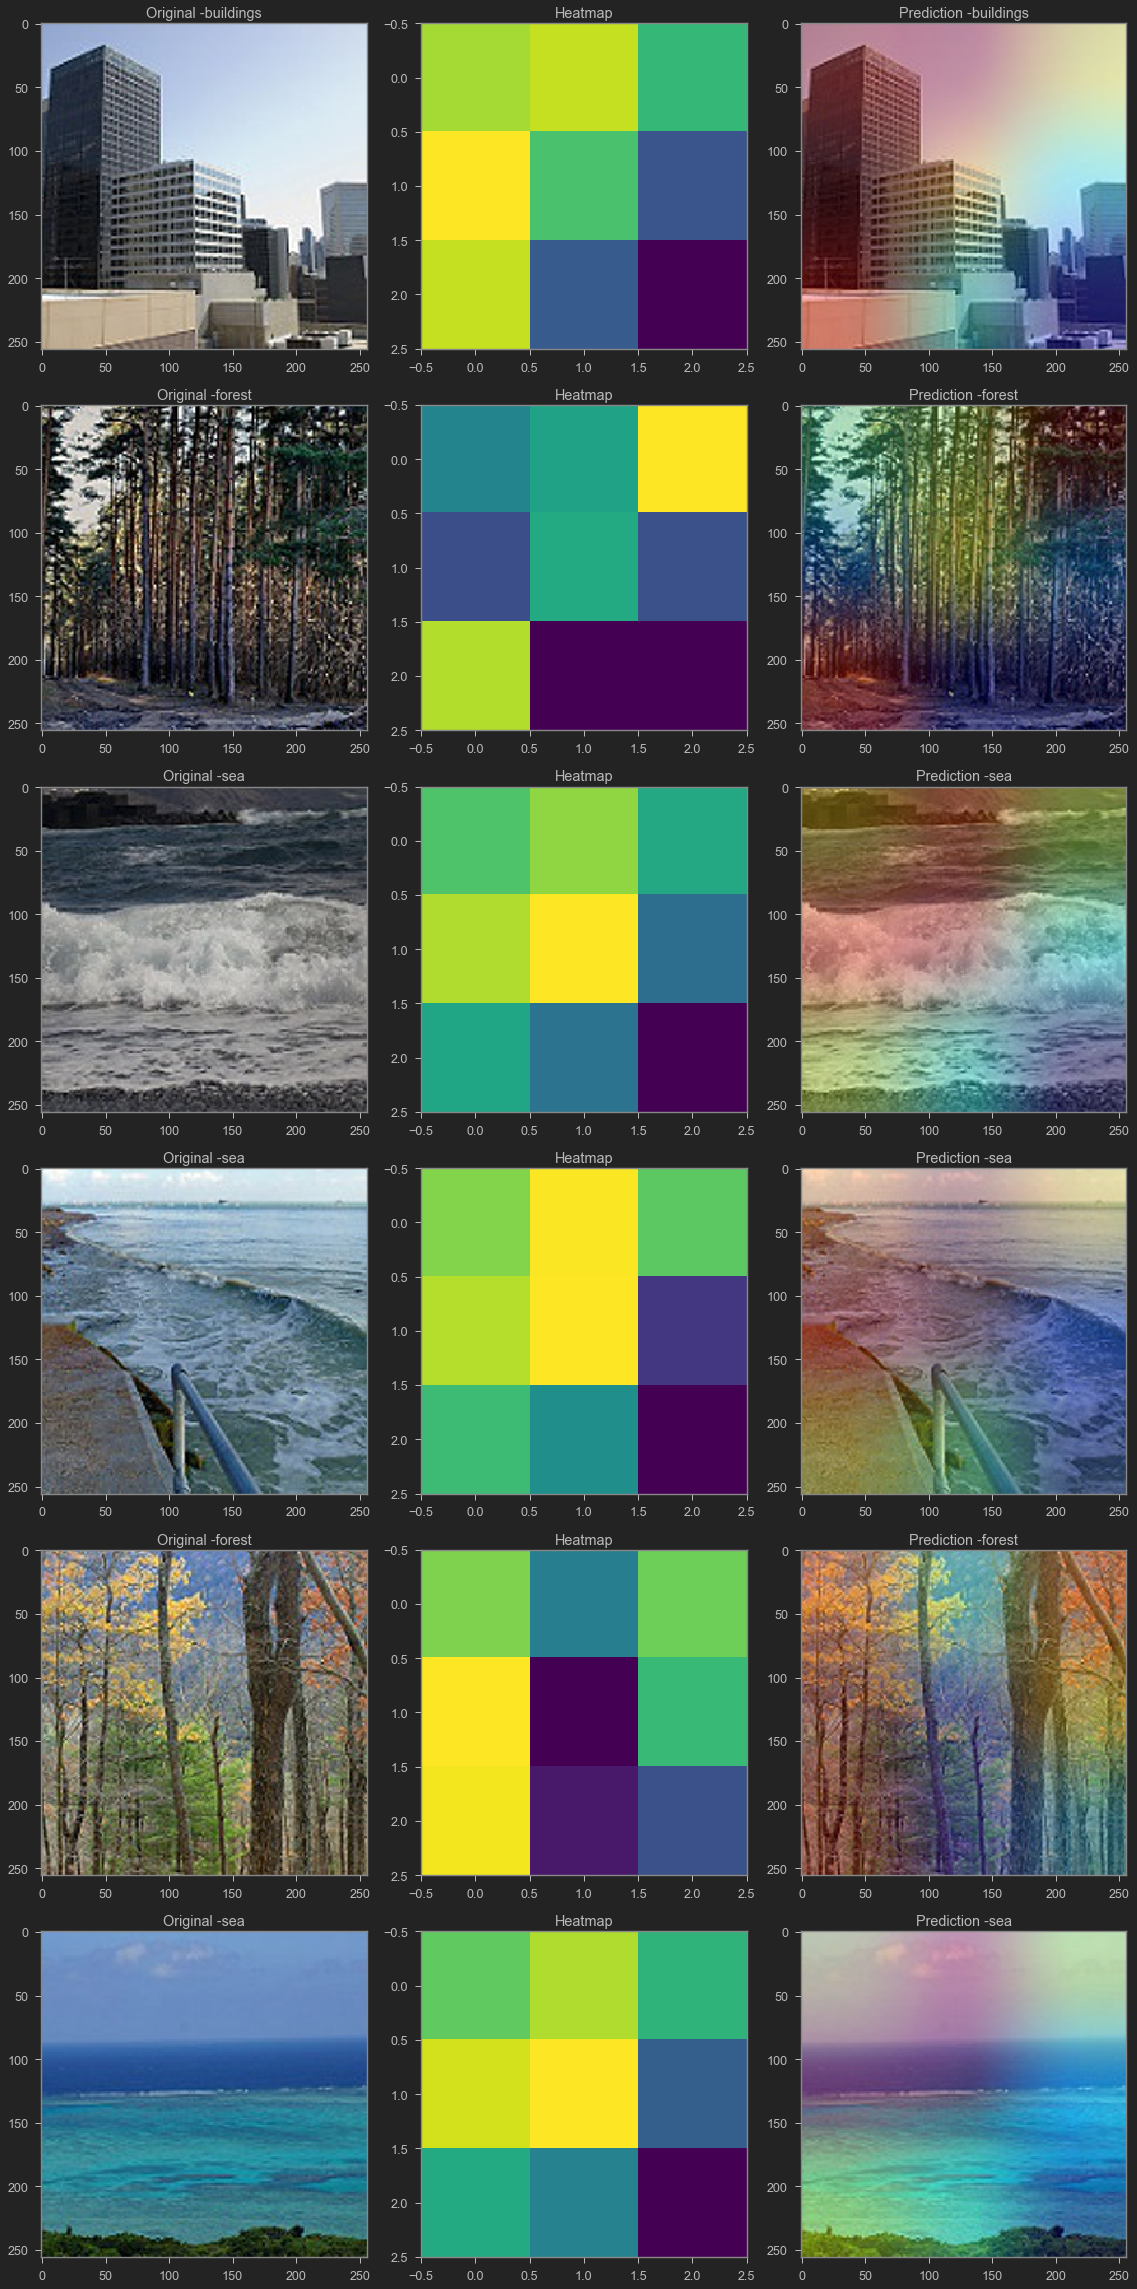

In [ ]:
# Visualize the images in the dataset
import random

fig, axs = plt.subplots(6, 3, figsize=(16, 32))
count = 0
for _ in range(6):
    i = random.randint(0, len(image))
    gradcam, heatmap = grad_cam(image[i])
    axs[count][0].title.set_text("Original -" + original[i])
    axs[count][0].imshow(image[i])
    axs[count][1].title.set_text("Heatmap")
    axs[count][1].imshow(heatmap)
    axs[count][2].title.set_text("Prediction -" + prediction[i])
    axs[count][2].imshow(gradcam)
    count += 1

fig.tight_layout()

# CONGRATULATIONS ON FINISHING THE PROJECT!


MINI CHALLENGE #1


In [ ]:
No_images_per_class = []
Class_name = []
for i in os.listdir("./seg_test"):
    train_class = os.listdir(os.path.join("seg_test", i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)

fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels=Class_name, autopct="%1.1f%%")
plt.show

MINI CHALLENGE #2


In [ ]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.3,
    dtype=None,
)

MINI CHALLENGE #3


Error is approximately 3.6%


MINI CHALLENGE #4


In [ ]:
def res_block(X, filter, stage):
    # Convolutional_block

    X_copy = X

    f1, f2, f3 = filter

    # Main Path
    X = Conv2D(
        f1,
        (1, 1),
        strides=(1, 1),
        name="res_" + str(stage) + "_conv_a",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name="bn_" + str(stage) + "_conv_a")(X)
    X = Activation("relu")(X)

    X = Conv2D(
        f2,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        name="res_" + str(stage) + "_conv_b",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name="bn_" + str(stage) + "_conv_b")(X)
    X = Activation("relu")(X)

    X = Conv2D(
        f3,
        kernel_size=(1, 1),
        strides=(1, 1),
        name="res_" + str(stage) + "_conv_c",
        kernel_initializer=glorot_uniform(seed=0),
    )(X)
    X = BatchNormalization(axis=3, name="bn_" + str(stage) + "_conv_c")(X)

    # Short path
    X_copy = Conv2D(
        f3,
        kernel_size=(1, 1),
        strides=(1, 1),
        name="res_" + str(stage) + "_conv_copy",
        kernel_initializer=glorot_uniform(seed=0),
    )(X_copy)
    X_copy = BatchNormalization(axis=3, name="bn_" + str(stage) + "_conv_copy")(X_copy)


In [ ]:
# Average Pooling
X = AveragePooling2D((2, 2), name="Averagea_Pooling")(X)

# Final layer
X = Flatten()(X)
X = Dropout(0.4)(X)
X = Dense(
    6,
    activation="softmax",
    name="Dense_final",
    kernel_initializer=glorot_uniform(seed=0),
)(X)

MINI CHALLENGE #5:


- Try optimizers like adam, ndam
- Change the value of patience to 25


MINI CHALLENGE #6:


In [ ]:
# print the classiication report
print(classification_report(np.asarray(prediction), np.asarray(original)))

In [ ]:
# plot the confusion matrix
plt.figure(figsize=(20, 20))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.set_xlabel("Predicted")
ax.set_ylabel("Original")
ax.set_title("Confusion_matrix")


MINI CHALLENGE #7:


By exploring the images, Glaciers contain mountains. This might be the reason of mixing up classes 2 and 3
